In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## K-Means

**Fit and predict**

Tạo dữ liệu và phân cụm:

In [8]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

Vẽ:

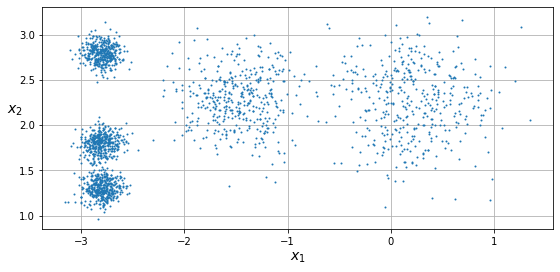

In [9]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
save_fig("blobs_plot")
plt.show()

Các mẫu đuợc gán cho 5 cụm

In [10]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [11]:
y_pred is kmeans.labels_

True

Lấy ra 5 điểm trung tâm:

In [12]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

“label” của một mẫu dữ liệu không phải là một giá trị mục tiêu (target) như trong các bài toán phân loại. Thay vào đó, “label” ở đây là chỉ số của cụm mà mẫu dữ liệu đó được gán vào.

In [13]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [14]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

**Ranh giới quyết định**

Hãy vẽ ranh giới quyết định của mô hình. Dùng biểu đồ Voronoi:

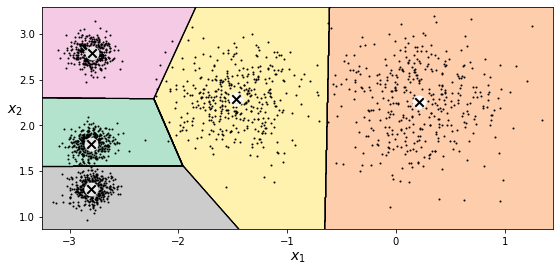

In [15]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

**Hard Clustering _vs_ Soft Clustering**

Thay vì gán mỗi mẫu dữ liệu vào một cụm duy nhất (gọi là hard clustering), có thể hữu ích nếu ta đánh giá mỗi mẫu dữ liệu dựa trên điểm số cho từng cụm (gọi là soft clustering). Điểm số này có thể là khoảng cách giữa mẫu dữ liệu và trung tâm cụm hoặc là một điểm tương đồng (hoặc độ tương quan). Trong lớp KMeans, phương thức transform() đo khoảng cách từ mỗi mẫu dữ liệu đến tất cả các trung tâm cụm.

In [16]:
kmeans.transform(X_new).round(2)

array([[2.81, 0.33, 2.9 , 1.49, 2.89],
       [5.81, 2.8 , 5.85, 4.48, 5.84],
       [1.21, 3.29, 0.29, 1.69, 1.71],
       [0.73, 3.22, 0.36, 1.55, 1.22]])

Bạn có thể xác minh rằng đây thực sự là khoảng cách Euclidian giữa mỗi mẫu và mỗi tâm:

In [17]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2)
               - kmeans.cluster_centers_, axis=2).round(2)

array([[2.81, 0.33, 2.9 , 1.49, 2.89],
       [5.81, 2.8 , 5.85, 4.48, 5.84],
       [1.21, 3.29, 0.29, 1.69, 1.71],
       [0.73, 3.22, 0.36, 1.55, 1.22]])

Hãy chạy thuật toán K-Means cho 1, 2 và 3 lần lặp để xem các điểm trung tâm di chuyển xung quanh như thế nào:

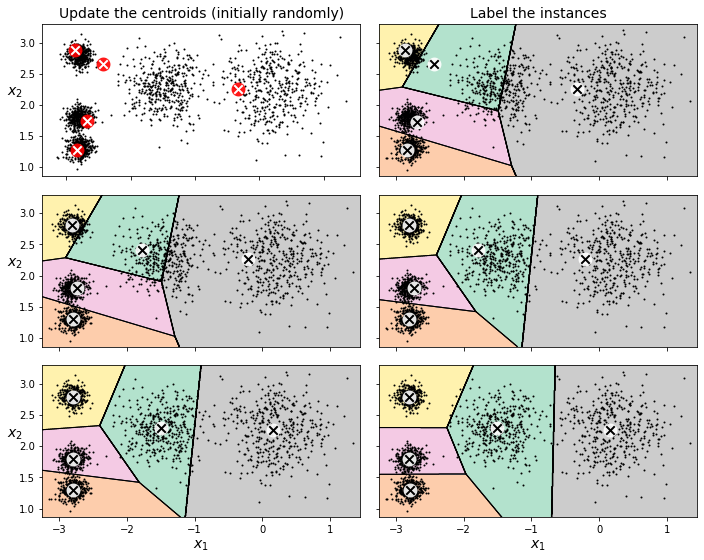

In [18]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=5)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=5)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=5)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

**K-Means biến thiên**

Trong thuật toán K-Means gốc, các trung tâm cụm được khởi tạo ngẫu nhiên, và thuật toán chỉ thực hiện một vòng lặp đơn để dần dần cải thiện các trung tâm cụm, như chúng ta đã thấy ở trên.

Tuy nhiên, một vấn đề lớn với phương pháp này là nếu bạn chạy K-Means nhiều lần (hoặc với các giá trị khởi tạo khác nhau), nó có thể hội tụ đến các giải pháp rất khác nhau, như bạn có thể thấy dưới đây:

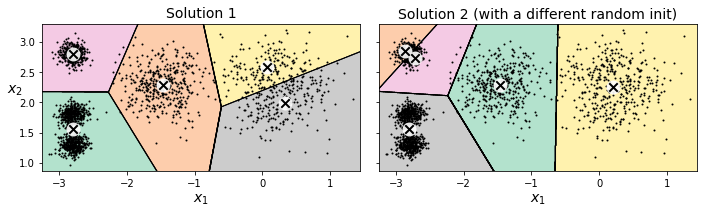

In [19]:

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1",
                          "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

In [20]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

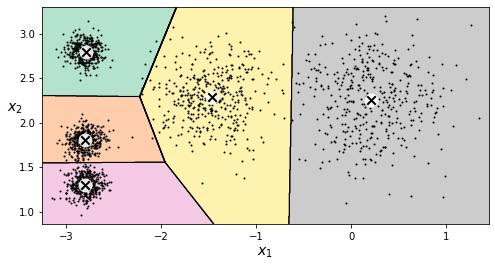

In [21]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

### Độ biến động (inertia)

Để chọn mô hình tốt nhất, chúng ta cần một cách để đánh giá hiệu suất của mô hình K-Means. Thật không may, phân cụm là một nhiệm vụ không giám sát, vì vậy chúng ta không có các giá trị mục tiêu. Nhưng ít nhất chúng ta có thể đo khoảng cách giữa mỗi mẫu dữ liệu và trung tâm cụm của nó. Đây chính là ý tưởng đằng sau chỉ số inertia:

In [22]:
kmeans.inertia_

211.59853725816836

In [23]:
kmeans_rnd_init1.inertia_  

219.43539442771404

In [24]:
kmeans_rnd_init2.inertia_  

258.64724728961636

Có thể dễ dàng xác minh, inertia là tổng bình phương khoảng cách giữa mỗi mẫu huấn luyện và trung tâm gần nhất của nó:

In [25]:

X_dist = kmeans.transform(X)
(X_dist[np.arange(len(X_dist)), kmeans.labels_] ** 2).sum()

211.59853725816856

Phương thức score() trả về giá trị âm của inertia (nó âm vì phương thức score() của một bộ dự đoán luôn phải tuân theo quy tắc “càng cao càng tốt” của Scikit-Learn: nếu một bộ dự đoán tốt hơn một bộ khác, phương thức score() của nó sẽ trả về một điểm số cao hơn).

In [26]:
kmeans.score(X)

-211.5985372581684

### Khởi tạo nhiều lần

Một cách để giải quyết vấn đề biến thiên là chạy thuật toán K-Means nhiều lần với các khởi tạo ngẫu nhiên khác nhau, sau đó chọn giải pháp có inertia nhỏ nhất.

Khi bạn thiết lập siêu tham số n_init, Scikit-Learn sẽ chạy thuật toán gốc n_init lần và chọn giải pháp có inertia nhỏ nhất. Mặc định, Scikit-Learn đặt n_init=10.

In [27]:

kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(init='random', n_clusters=5, random_state=2)

Như bạn có thể thấy, chúng ta cuối cùng thu được mô hình ban đầu, mà chắc chắn là giải pháp K-Means tối ưu (ít nhất là về khả năng giảm độ biến động, và giả định k=5)

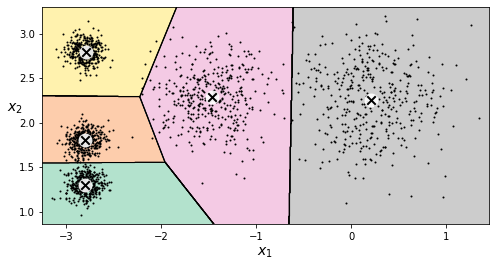

In [28]:

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

In [29]:
kmeans_rnd_10_inits.inertia_

211.5985372581684

### Centroid initialization methods

Thay vì khởi tạo các trung tâm cụm hoàn toàn ngẫu nhiên, việc khởi tạo chúng bằng thuật toán sau đây được đề xuất trong một [bài báo năm 2006](https://goo.gl/eNUPw6) của David Arthur và Sergei Vassilvitskii:

1. Chọn một trung tâm cụm $c_1$ ngẫu nhiên từ tập dữ liệu.
2. Chọn một trung tâm mới $c_i$ bằng cách chọn một mẫu $\mathbf{x}_i$ với xác suất: $$\frac{{D(\mathbf{x}_i)^2}}{{\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2}}$$ trong đó $D(\mathbf{x}_i)$ là khoảng cách giữa mẫu $\mathbf{x}_i$ và trung tâm cụm gần nhất đã được chọn trước đó. Phân phối xác suất này đảm bảo rằng các mẫu dữ liệu cách xa các trung tâm cụm đã chọn sẽ có khả năng cao hơn để được chọn làm trung tâm cụm.
3. Lặp lại bước trước cho đến khi chọn đủ $k$ trung tâm cụm.

Phần còn lại của thuật toán **K-Means++** giống với thuật toán **K-Means** thông thường. Với việc khởi tạo này, thuật toán **K-Means** ít có khả năng hội tụ đến một giải pháp kém hơn, do đó có thể giảm `n_init` một cách đáng kể. Hầu hết thời gian, điều này đủ để bù đắp cho sự phức tạp bổ sung của quá trình khởi tạo.

Để thiết lập khởi tạo bằng **K-Means++**, bạn chỉ cần đặt `init="k-means++"` (điều này thực tế là giá trị mặc định)

### Tăng tốc K-Means

Thuật toán **K-Means** đôi khi có thể được tăng tốc bằng cách tránh nhiều phép tính khoảng cách không cần thiết: điều này được thực hiện bằng cách tận dụng bất đẳng thức tam giác (cho ba điểm A, B và C, khoảng cách AC luôn thỏa mãn AC ≤ AB + BC) và theo dõi giới hạn dưới và giới hạn trên cho khoảng cách giữa các mẫu dữ liệu và trung tâm cụm (xem [bài báo năm 2003](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) của Charles Elkan để biết thêm chi tiết).

Đối với biến thể **K-Means** của Elkan, bạn có thể sử dụng `algorithm="elkan"`. Đối với **KMeans** thông thường, bạn có thể sử dụng `algorithm="full"`. Giá trị mặc định là `"auto"`, từ phiên bản Scikit-Learn 1.1 trở đi (trước đó, nó sử dụng thuật toán của Elkan).

### Mini-Batch K-Means

Scikit-Learn cũng triển khai một biến thể của thuật toán **K-Means** hỗ trợ mini-batches (xem [bài báo này](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)).

In [30]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [31]:
minibatch_kmeans.inertia_

211.65239850433204

Dưới đây là biểu đồ so sánh tỷ lệ inertia và tỷ lệ thời gian huấn luyện giữa **Mini-batch K-Means** và **K-Means** thông thường:

100/100

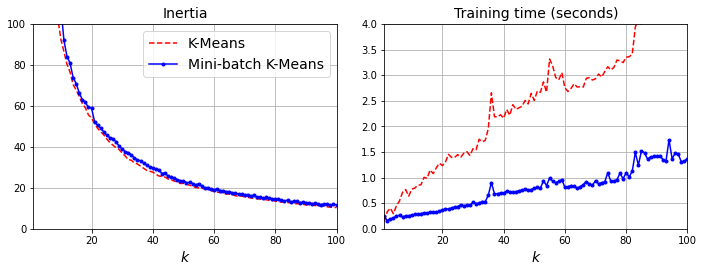

In [36]:
from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    kmeans_ = KMeans(n_clusters=k, algorithm="lloyd", n_init=10, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
    print(f"\r{k}/{max_k}", end="")  # \r returns to the start of line
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10,
                             globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Inertia")
plt.legend()
plt.axis([1, max_k, 0, 100])
plt.grid()

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Training time (seconds)")
plt.axis([1, max_k, 0, 4])
plt.grid()

save_fig("minibatch_kmeans_vs_kmeans_plot")
plt.show()

### Tìm số cụm tối ưu

Điều gì sẽ xảy ra nếu số lượng cụm được đặt thành giá trị thấp hơn hoặc lớn hơn 5?

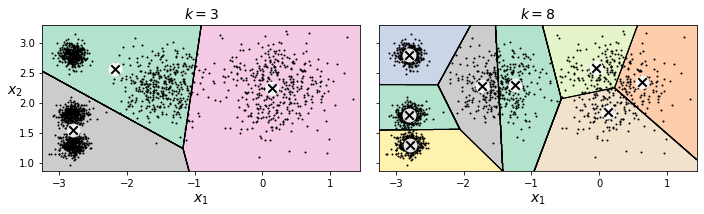

In [37]:
kmeans_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

2 mô hình trông không đẹp lắm, vậy inertia thì sao?

In [38]:
kmeans_k3.inertia_

653.2167190021554

In [39]:
kmeans_k8.inertia_

119.11983416102882

Đúng vậy, chúng ta không thể đơn giản chọn giá trị của $k$ sao cho inertia là nhỏ nhất, vì nó sẽ tiếp tục giảm khi chúng ta tăng $k$. Thực tế, càng có nhiều cụm, mỗi mẫu dữ liệu sẽ càng gần với trung tâm cụm gần nhất của nó, và do đó inertia sẽ càng thấp hơn. Tuy nhiên, chúng ta có thể vẽ biểu đồ inertia theo hàm số của $k$ và phân tích đường cong kết quả:

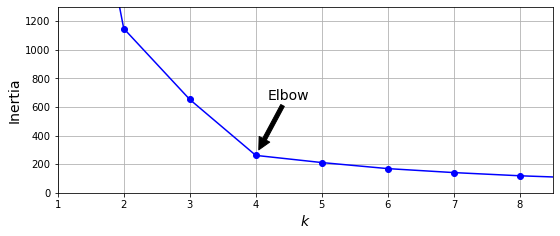

In [40]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
save_fig("inertia_vs_k_plot")
plt.show()

Đường cong “khuỷu tay” ở k=4 cho thấy rằng nếu chọn ít hơn 4 cụm, kết quả sẽ không tốt, và nếu chọn nhiều hơn 4 cụm, sẽ không giúp nhiều và có thể chia cụm ra làm nửa. Vì vậy, k=4 là một lựa chọn khá tốt. Tất nhiên, trong ví dụ này nó không hoàn hảo vì có nghĩa là hai vùng dữ liệu ở góc dưới bên trái sẽ được xem xét là một cụm duy nhất, nhưng vẫn là một phân cụm khá tốt.

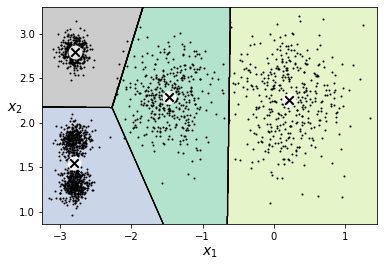

In [41]:

plot_decision_boundaries(kmeans_per_k[4 - 1], X)
plt.show()

Một cách tiếp cận khác là xem xét _điểm silhouette_ (silhouette score), đó là trung bình của _hệ số silhouette_ trên tất cả các mẫu dữ liệu. Hệ số silhouette của một mẫu dữ liệu bằng (_b_ - _a_) / max(_a_, _b_), trong đó:
- _a_ là khoảng cách trung bình đến các mẫu dữ liệu khác trong cùng một cụm (đây là _khoảng cách nội-cụm trung bình_).
- _b_ là _khoảng cách trung bình đến cụm gần nhất_, tức là khoảng cách trung bình đến các mẫu dữ liệu của cụm gần nhất (được xác định là cụm mà giá trị _b_ là nhỏ nhất, loại trừ cụm của chính mẫu dữ liệu đó).

Hệ số silhouette có thể thay đổi trong khoảng từ -1 đến +1:
- Giá trị gần +1 cho thấy mẫu dữ liệu nằm sâu trong cụm của nó và xa các cụm khác.
- Giá trị gần 0 cho thấy mẫu dữ liệu gần biên của cụm.
- Giá trị gần -1 cho thấy mẫu dữ liệu có thể đã được gán vào cụm sai.

Hãy vẽ điểm silhouette dưới dạng hàm của $k$:

In [42]:
from sklearn.metrics import silhouette_score

In [43]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

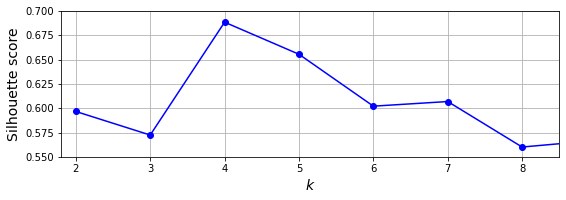

In [44]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
save_fig("silhouette_score_vs_k_plot")
plt.show()

Như bạn đã thấy, biểu đồ này phong phú hơn rất nhiều so với biểu đồ trước: đặc biệt, mặc dù nó xác nhận rằng $k=4$ là một lựa chọn rất tốt, nhưng cũng nhấn mạnh rằng $k=5$ cũng khá tốt.

Một biểu đồ hữu ích hơn nữa là khi bạn vẽ hệ số silhouette của từng mẫu dữ liệu, được sắp xếp theo cụm mà chúng được gán vào và theo giá trị của hệ số. Đây được gọi là một _biểu đồ silhouette_ (silhouette diagram).

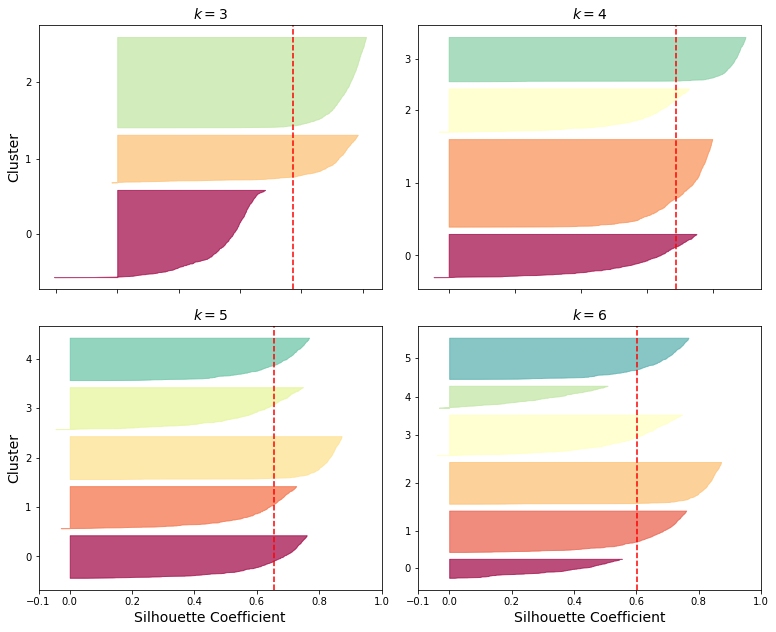

In [45]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig("silhouette_analysis_plot")
plt.show()

Dựa vào hình vẽ, ta thấy rằng lựa chọn $k=5$ có vẻ là tốt nhất ở đây. Tất cả các cụm đều có kích thước gần như bằng nhau và đều vượt qua đường kẻ đứt, biểu thị cho điểm silhouette trung bình.

## Limits of K-Means

Hãy tạo một tập dữ liệu khó hơn, với các đốm màu kéo dài và mật độ khác nhau, đồng thời cho thấy rằng K-Means gặp khó khăn trong việc phân cụm nó một cách chính xác:

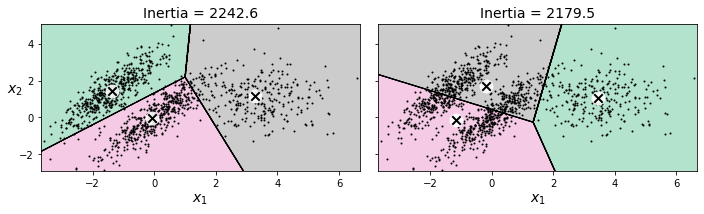

In [46]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3,
                     init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                     n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"Inertia = {kmeans_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"Inertia = {kmeans_bad.inertia_:.1f}")

save_fig("bad_kmeans_plot")
plt.show()

## DBSCAN

In [65]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [66]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [67]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [68]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

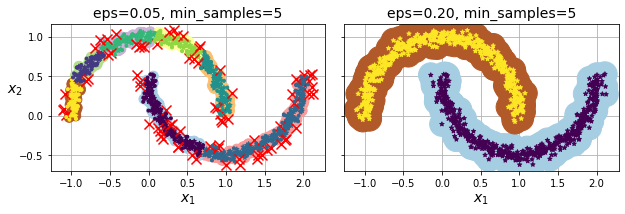

In [69]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

In [70]:
dbscan = dbscan2

Thật bất ngờ, lớp DBSCAN không có phương thức predict(), mặc dù nó có phương thức fit_predict(). Nó không thể dự đoán mẫu dữ liệu mới thuộc cụm nào. Quyết định này được đưa ra vì các thuật toán phân loại khác nhau có thể phù hợp hơn cho các nhiệm vụ khác nhau. Hơn nữa, việc triển khai không khó. Ví dụ, chúng ta có thể huấn luyện một bộ phân loại KNeighborsClassifier:

In [71]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [72]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [73]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

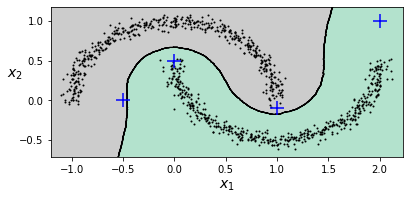

In [74]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [75]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])